<a href="https://colab.research.google.com/github/ibrahim1023/ml-fundamentals/blob/main/Logsitic_Regression_GD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# ML-Fundamentals — Logistic Regression (from scratch)

This notebook walks you through:
1. What logistic regression is (short recap)
2. Building it **from scratch** with NumPy
3. Training with cross-entropy loss and gradient descent
4. Visualizing the decision boundary and the loss curve
5. Optional: comparing with `scikit-learn`



## 1) Short math recap

We model the probability of the positive class as
$$
h_\theta(x) = \sigma(\theta^\top x) = \frac{1}{1 + e^{-\theta^\top x}}.$$
where \(\sigma\) is the sigmoid.

For binary labels \(y \in \{0,1\}\), the (negative) log-likelihood (a.k.a. cross-entropy loss) over \(m\) examples is
$$
J(\theta) = -\frac{1}{m}\sum_{i=1}^m \Big(y^{(i)} \log h_\theta(x^{(i)}) + (1-y^{(i)})\log(1-h_\theta(x^{(i)}))\Big.$$

Gradient of \(J(\theta)\) is
$$
\nabla_\theta J(\theta) = \frac{1}{m} X^\top \big(h_\theta(X) - y\big)$$
where \(X\) is the design matrix (with an intercept column of 1s), and \(h_\theta(X)=\sigma(X\theta)\).

**Gradient descent** update:
$$
\theta \leftarrow \theta - \alpha \, \nabla_\theta J(\theta).$$


In [10]:

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(7)
print("NumPy:", np.__version__)


NumPy: 2.0.2



## 2) Generate a simple 2D dataset

We'll create two Gaussian blobs in 2D:
- Class 0 centered at \([-1.0, -1.0]\)
- Class 1 centered at \([+1.0, +1.0]\)

Then we'll add an **intercept** column to the feature matrix.


In [11]:

# Create two clusters
n0, n1 = 100, 100
mean0, mean1 = np.array([-1.0, -1.0]), np.array([+1.0, +1.0])
cov = np.array([[0.6, 0.0],[0.0, 0.6]])

X0 = np.random.multivariate_normal(mean0, cov, size=n0)
X1 = np.random.multivariate_normal(mean1, cov, size=n1)

X = np.vstack([X0, X1])
y = np.concatenate([np.zeros(n0, dtype=int), np.ones(n1, dtype=int)])

# Shuffle
perm = np.random.permutation(len(y))
X, y = X[perm], y[perm]

# Add intercept column
X_with_bias = np.hstack([np.ones((X.shape[0], 1)), X])

X.shape, X_with_bias.shape, y.shape


((200, 2), (200, 3), (200,))


### Visualize the dataset


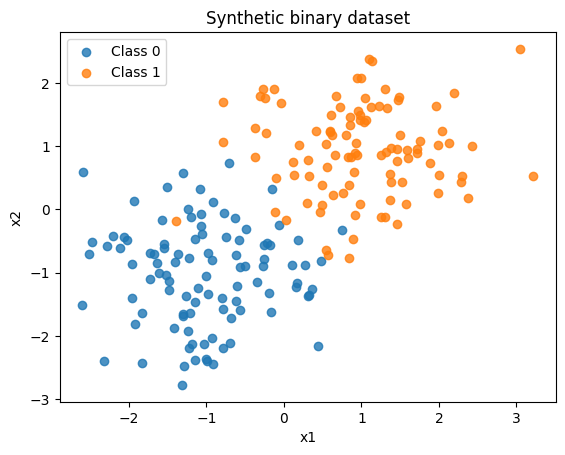

In [12]:

plt.figure()
mask1 = (y == 1)
mask0 = (y == 0)
plt.scatter(X[mask0, 0], X[mask0, 1], label="Class 0", alpha=0.8)
plt.scatter(X[mask1, 0], X[mask1, 1], label="Class 1", alpha=0.8)
plt.legend()
plt.title("Synthetic binary dataset")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()



## 3) From-scratch logistic regression (NumPy)

We'll implement:
- `sigmoid(z)`
- `predict_proba(theta, X)`
- `loss(theta, X, y)` (binary cross-entropy)
- `grad(theta, X, y)`
- a simple `fit` loop using gradient descent


In [13]:

def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def predict_proba(theta, Xb):
    return sigmoid(Xb @ theta)

def loss(theta, Xb, y):
    p = predict_proba(theta, Xb)
    # Clip for numerical stability
    eps = 1e-12
    p = np.clip(p, eps, 1 - eps)
    return -np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))

def grad(theta, Xb, y):
    p = predict_proba(theta, Xb)
    return (Xb.T @ (p - y)) / len(y)

def accuracy(theta, Xb, y):
    p = predict_proba(theta, Xb)
    yhat = (p >= 0.5).astype(int)
    return (yhat == y).mean()



### Train with gradient descent


In [14]:

def fit_logreg_gd(Xb, y, lr=0.1, epochs=2000, verbose_every=200):
    theta = np.zeros(Xb.shape[1])
    history = {"loss": [], "acc": []}
    for t in range(epochs):
        g = grad(theta, Xb, y)
        theta = theta - lr * g
        if (t % verbose_every == 0) or (t == epochs - 1):
            cur_loss = loss(theta, Xb, y)
            cur_acc = accuracy(theta, Xb, y)
            history["loss"].append(cur_loss)
            history["acc"].append(cur_acc)
    return theta, history

theta, hist = fit_logreg_gd(X_with_bias, y, lr=0.1, epochs=2000, verbose_every=50)
print("theta learned:", theta)
print("final loss:", hist["loss"][-1])
print("final acc:", hist["acc"][-1])


theta learned: [0.32828156 3.0896628  3.16899139]
final loss: 0.08677719853526061
final acc: 0.96



### Loss curve


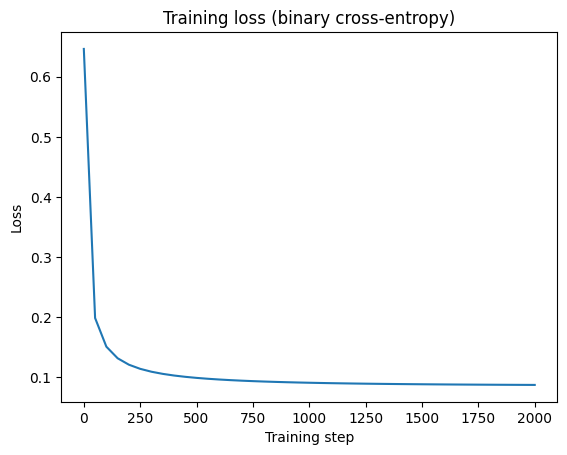

In [15]:

plt.figure()
steps = np.arange(len(hist["loss"])) * 50  # since verbose_every=50
plt.plot(steps, hist["loss"])
plt.title("Training loss (binary cross-entropy)")
plt.xlabel("Training step")
plt.ylabel("Loss")
plt.show()



### Decision boundary (for 2D features)

For $$\theta = [\theta_0, \theta_1, \theta_2],  input= [1, x_1, x_2].$$, the boundary is
$$
\theta_0 + \theta_1 x_1 + \theta_2 x_2 = 0 \;\Rightarrow\; x_2 = -\frac{\theta_0 + \theta_1 x_1}{\theta_2}$$


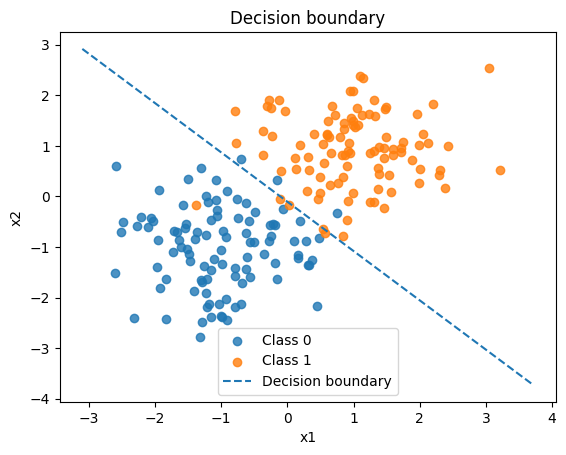

In [16]:

plt.figure()
plt.scatter(X[mask0, 0], X[mask0, 1], label="Class 0", alpha=0.8)
plt.scatter(X[mask1, 0], X[mask1, 1], label="Class 1", alpha=0.8)

# Draw decision boundary
b, w1, w2 = theta
xx = np.linspace(X[:,0].min()-0.5, X[:,0].max()+0.5, 200)
# Avoid division by zero if w2 ~ 0
if abs(w2) < 1e-9:
    # vertical line case: w1 * x1 + b = 0
    x_vert = -b / (w1 + 1e-12)
    plt.axvline(x=x_vert, linestyle="--")
else:
    yy = -(b + w1 * xx) / w2
    plt.plot(xx, yy, linestyle="--", label="Decision boundary")

plt.legend()
plt.title("Decision boundary")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()



### Quick predictions


In [17]:

def predict(theta, Xb):
    return (predict_proba(theta, Xb) >= 0.5).astype(int)

print("First 10 predicted labels:", predict(theta, X_with_bias)[:10])
print("First 10 true labels     :", y[:10])
print("Training accuracy        :", accuracy(theta, X_with_bias, y))


First 10 predicted labels: [0 1 0 0 1 1 1 0 0 1]
First 10 true labels     : [0 1 0 0 1 1 1 0 0 1]
Training accuracy        : 0.96



## 4) (Optional) Compare with scikit-learn

If you're running in Google Colab or an environment with `scikit-learn` installed, you can run this cell to compare.


In [18]:

try:
    from sklearn.linear_model import LogisticRegression as SKLogReg
    clf = SKLogReg(fit_intercept=True)  # scikit-learn adds intercept internally
    clf.fit(X, y)
    sk_acc = clf.score(X, y)
    print("scikit-learn accuracy:", sk_acc)
    print("Our from-scratch accuracy:", accuracy(theta, X_with_bias, y))
except Exception as e:
    print("scikit-learn not available in this environment:", repr(e))


scikit-learn accuracy: 0.96
Our from-scratch accuracy: 0.96
